<a href="https://colab.research.google.com/github/rashwin88/gan_clip_notebooks/blob/main/GANClipCodingSession1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we will have to import all the necessary libraries that will help build GANs.
1. `pdb` is used for debugging.
2. `DataLoader1 is used to create iterables out of training data. Look further in the notebook for how iterables work.
3. `make_grid` is used to draw or show the images that the Generator is producing.
4. `tqdm` for beautiful progress bars and such.

We also set up a standard logger so that we can see what is going on an debug as necessary.
 Need to write something on DataLoader

In [1]:
!nvidia-smi

Thu Aug 14 17:11:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import torch
import pdb # For debugging
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
# Set up some basic logging configurations
import sys
import os
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
)

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.info("Setting up logging for the project")

INFO:__main__:Setting up logging for the project


### Basic Visualization Functions
As we train, we will want to show some grid of generated images vs some real images. So we will develop some convenience functions for the same. This is actually pretty interesting because it involves some tensor operations that can seem confusing at first. The idea is to display a 4x4 grid of images (which are images output by the network or are images that are inputs from the DataLoader).

Details:
1. `make_grid` returns a tensor. We re permute it into a different format so that matplotlib can handle it. Notice that the channels go to the last in this case.
2. Prior to that we perform a `detach()` operation and create a view. Note the -1 in the beginning of the view represents all remaining dimensions in this case this is the batch size.


In [3]:
from typing import Tuple
def show(tensor, channels: int = 1, size: Tuple = (28,28), num: int = 16):
  """
  Displays a a set of images in a grid.

  Args:
    tensor: The tensor containing the images
    channels: The number of channels in each image.
    size: The number of width and height pixels (in that order in the image)
    num: The number of images to be displayed.
  """
  # input tensor is generally 128 X 784 in size
  logger.debug("Initializing image display")
  logger.info("Detaching tensor from GPU and attaching it to CPU and resizing")
  data = tensor.detach().cpu().view(-1, channels, *size) # Batch Size X Channels X Width X Height
  logger.debug("Creating grid")
  grid = make_grid(data[:num], nrow=4).permute(1,2,0) # Channels X Width X Height -> Width X Height X Channels
  plt.imshow(grid)
  plt.show()

### Coding Hyperparameters and the DataLoader
Note that `BCEWithLogitsLoss()` is much more numerically stable and will be out primary loss function.

The primary thing to understand here is how the DataLoader works - internal notes will have more of this information.

In [4]:
epochs = 500
cur_step = 0
info_step = 300 # How many steps for info (each step processes a batch)
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64 # Dimensionality of the vector space that is the input for noise.
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

batch_size = 128
device = 'cuda' # Parallel processing

# TODO More reseach on this
dataloader = DataLoader(
    MNIST('.',
          download=True,
          transform = transforms.ToTensor()),
    shuffle = True,
    batch_size = batch_size
)

# Number of steps = 60,000 images / batch_size (128) = 469 steps.
# The last step will have a smaller size of the batch


### Coding out a generator block

Basically we are coding a Neural net with 5 hidden layers, the last layer is a linear layer followed by a sigmoid function. The last layer produces an output of size 784 which is the number of pixels in the MNIST images.

Internal notes: How the BatchNorm layer works.

In [5]:
# Fist we will code out a generator block.
def genBlock(inp, out):
  """
  Defines a generator block
  """
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out), # Normalizes values
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim = 128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim),
        genBlock(h_dim, h_dim*2),
        genBlock(h_dim*2, h_dim*4),
        genBlock(h_dim*4, h_dim*8),
        nn.Linear(h_dim*8, i_dim),
        nn.Sigmoid()
    )

  def forward(self, noise):
    return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      # nn.BatchNorm1d(out),
      nn.LeakyReLU(0.2) # To avoid dying Relu
  )

class Discriminator(nn.Module):
  """
  Input is an image
  """
  def __init__(self, i_dim = 784, h_dim=256):
    super().__init__()
    self.discrim = nn.Sequential(
        discBlock(i_dim, h_dim*4),
        discBlock(h_dim*4, h_dim*2),
        discBlock(h_dim*2, h_dim),
        nn.Linear(h_dim, 1)
    )
  def forward(self, image):
    return self.discrim(image)

### Coding the Optimizer


In [6]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr = lr)

### Some fun

INFO:__main__:Detaching tensor from GPU and attaching it to CPU and resizing


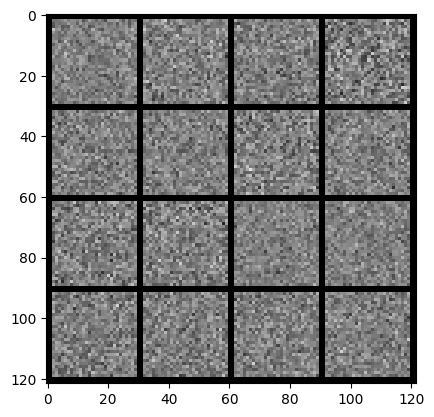

In [7]:
x, y = next(iter(dataloader))
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

### Computing loss
Trying to write these functions for loss computation by myself so that it becomes easier later on.

In [8]:
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  """
  Calculates the loss of the generator
  """
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred)
  return loss_func(pred, targets)

def calc_disc_loss(loss_func, gen, disc, real, number, z_dim):
  """
  Calculates the blended loss of the discriminator
  """
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  disc_fake = disc(fake.detach())
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real, disc_real_targets)
  return (disc_fake_loss + disc_real_loss)/2


### The Training loop
We will code the generator and a discriminator training loop seperately.

In [ ]:
for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    # Discriminator
    # First get the size of the batch in case this is the last batch
    disc_opt.zero_grad()
    size = len(real)
    # Mutate real
    real = real.view(size, -1) # bs * 784
    real = real.to(device)
    # Calculate the loss
    disc_loss = calc_disc_loss(
        loss_func,
        gen,
        disc,
        real,
        size,
        z_dim
    )
    disc_loss.backward()
    disc_opt.step()

    ## generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(
        loss_func,
        gen,
        disc,
        size,
        z_dim
    )
    gen_loss.backward()
    gen_opt.step()

    ## Stats and visuals
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if (cur_step % info_step == 0) and cur_step != 0:
      fake_noise = gen_noise(size, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} Gen Loss: {mean_gen_loss} Disc Loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss = 0, 0
    cur_step+=1
